# Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

print('numpy', np.__version__)
print('pandas', pd.__version__)
print('matplotlib', matplotlib.__version__)
print('seaborn', sns.__version__)

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200715034250-0000
KERNEL_ID = 580f8d93-7490-4679-8b22-8379f2ac67f7
numpy 1.15.4
pandas 0.24.1
matplotlib 3.0.2
seaborn 0.9.0


# Importing the dataset

In [2]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_62d16fde9ee64a49b809102844695402 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='XSCASHjDajDxaWQPvUeAapDDHRz6wRS_Hd2vgjN-IDMf',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_62d16fde9ee64a49b809102844695402.get_object(Bucket='predictingtheenergyoutputofwindtu-donotdelete-pr-4zv0a0xlcw57fc',Key='Dataset.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

dataset = pd.read_excel(body)
dataset.head()

,Date/Time,Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction,maxtempC,windGustKmph,DewPointC,windChillC,humidity,pressure,LV ActivePower
0,2018-01-01 00:00:00,5.311336,416.328908,259.994904,10,11.125,2.208333,6.333333,69.916667,1017.625,380.047791
1,2018-01-01 00:10:00,5.672167,519.917511,268.641113,10,11.125,2.208333,6.333333,69.916667,1017.625,453.769196
2,2018-01-01 00:20:00,5.216037,390.900016,272.564789,10,11.125,2.208333,6.333333,69.916667,1017.625,306.376587
3,2018-01-01 00:30:00,5.659674,516.127569,271.258087,10,11.125,2.208333,6.333333,69.916667,1017.625,419.645905
4,2018-01-01 00:40:00,5.577941,491.702972,265.674286,10,11.125,2.208333,6.333333,69.916667,1017.625,380.650696


In [3]:
# Separating Date and Time
dataset['Date/Time'] = pd.to_datetime(dataset['Date/Time'],format='%d %m %Y %H:%M')
dataset['Hour'] = dataset['Date/Time'].dt.hour
dataset['Minute'] = dataset['Date/Time'].dt.minute
dataset['Day'] = dataset['Date/Time'].dt.day
dataset['Month'] = dataset['Date/Time'].dt.month
dataset['Year'] = dataset['Date/Time'].dt.year
dataset = dataset.reindex(columns = ['Date/Time', 'Minute', 'Hour', 'Day', 'Month', 'Year', 'Wind Speed (m/s)' ,'Theoretical_Power_Curve (KWh)',
                                     'Wind Direction', 'maxtempC', 'windGustKmph', 'DewPointC', 'windChillC', 'humidity', 'pressure',
                                     'LV ActivePower'])
dataset.head()

,Date/Time,Minute,Hour,Day,Month,Year,Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction,maxtempC,windGustKmph,DewPointC,windChillC,humidity,pressure,LV ActivePower
0,2018-01-01 00:00:00,0,0,1,1,2018,5.311336,416.328908,259.994904,10,11.125,2.208333,6.333333,69.916667,1017.625,380.047791
1,2018-01-01 00:10:00,10,0,1,1,2018,5.672167,519.917511,268.641113,10,11.125,2.208333,6.333333,69.916667,1017.625,453.769196
2,2018-01-01 00:20:00,20,0,1,1,2018,5.216037,390.900016,272.564789,10,11.125,2.208333,6.333333,69.916667,1017.625,306.376587
3,2018-01-01 00:30:00,30,0,1,1,2018,5.659674,516.127569,271.258087,10,11.125,2.208333,6.333333,69.916667,1017.625,419.645905
4,2018-01-01 00:40:00,40,0,1,1,2018,5.577941,491.702972,265.674286,10,11.125,2.208333,6.333333,69.916667,1017.625,380.650696


### Drop column Wind Speed (m/s), maxtempC, DewPointC	

In [4]:
dataset.shape

(50530, 16)

# Data Preprocessing

In [5]:
# Splitting the dataset into X and Y
X = dataset.iloc[:, 1:15].values
y = dataset.iloc[:, -1].values
print('Shape of X =', X.shape)
print('Shape of y =', y.shape)

Shape of X = (50530, 14)
Shape of y = (50530,)


In [6]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = X[0:46083, :], X[46083:50531, :], y[0:46083], y[46083:50531]
print('Train set size is', y_train.size)
print('Test set size is', y_test.size)

Train set size is 46083
Test set size is 4447


In [7]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Finding suitable regression model

In [8]:
# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [9]:
# Fitting SVR to the dataset
from sklearn.svm import SVR
svr = SVR(kernel = 'rbf')
svr.fit(X_train, y_train)

/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [10]:
# Fitting Decision Tree Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state = 0)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [11]:
# Fitting Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 10, random_state = 0, n_jobs = -1)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [12]:
# Fitting xgboost Regression to the dataset
import xgboost as xgb
xgbr = xgb.XGBRegressor(n_jobs= -1)
xgbr.fit(X_train, y_train)

[12:17:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

# Printing the Accuracies

In [13]:
regression = {0:'LinearRegression', 1:'SVR', 2:'DecisionTreeRegressor', 3:'RandomForestRegressor', 4:'xgboost'}
reg = {0:linr, 1:svr, 2:dtr, 3:rfr, 4:xgbr}
y_pred = {0:'y_lin', 1:'y_svr', 2:'y_dtr', 3:'y_rfr', 4:'y_xgb'}

In [14]:
for i in range(0, 5):
    print('\n\n-------------------------------------------------------------------------------')
    print('Type of regression model: {}'.format(regression[i]))
    # Predicting a new result
    y_pred[i] = reg[i].predict(X_test)
    # calculate MAE, MSE, RMSE and r2
    import sklearn.metrics as metrics
    print('Mean Absolute Error (MAE) = ',metrics.mean_absolute_error(y_test, y_pred[i]))
    print('Mean Squared Error (MSE) = ',metrics.mean_squared_error(y_test, y_pred[i]))
    print('Root Mean Squared Error (RMSE) = ',np.sqrt(metrics.mean_squared_error(y_test, y_pred[i])))
    print('R2 Score = ',metrics.r2_score(y_test, y_pred[i]))
    print('-------------------------------------------------------------------------------')



-------------------------------------------------------------------------------
Type of regression model: LinearRegression
Mean Absolute Error (MAE) =  309.77701112308023
Mean Squared Error (MSE) =  304746.1300027345
Root Mean Squared Error (RMSE) =  552.038159915358
R2 Score =  0.8385933969424075
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Type of regression model: SVR
Mean Absolute Error (MAE) =  707.4493899916212
Mean Squared Error (MSE) =  679882.783164634
Root Mean Squared Error (RMSE) =  824.5500489143361
R2 Score =  0.6399049579170679
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Type of regression model: DecisionTreeRegressor
Mean Absolute Error (MAE) =  296.005004495042
Mean Squared Error (MSE) =  486674.5459439038
Root Mean Squared Error (RMSE)

# Most Accurate

In [15]:
# Applying k-Fold Cross Validation (xgboost)
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = xgbr, X = X_train, y = y_train, cv = 10)
print('Accuracies mean = ',accuracies.mean())
print('Accuracies standard deviation = ' ,accuracies.std())

[12:19:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:20:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:21:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:23:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:26:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:28:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:30:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [16]:
# Applying k-Fold Cross Validation (RandomForestRegressor)
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = rfr, X = X_train, y = y_train, cv = 10)
print('Accuracies mean = ',accuracies.mean())
print('Accuracies standard deviation = ' ,accuracies.std())

Accuracies mean =  0.9240604780459389
Accuracies standard deviation =  0.07800189800148695


# Applying Grid Search to find the best parameters

In [17]:
xgbr.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
# First Run
from sklearn.model_selection import GridSearchCV
parameters = [{'n_estimators': [80, 90, 100, 110, 120],
              'base_score': [0.3, 0.4, 0.5, 0.6, 0.7],
              'learning_rate': [0.05, 0.090, 0.095, 0.1, 0.105, 0.11, 0.2],
              'booster': ['gbtree', 'gblinear', 'dart']}]
grid_search = GridSearchCV(estimator = xgbr,
                           param_grid = parameters,
                           scoring = 'r2',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_accuracy)
print(best_parameters)

In [22]:
# Second Run
from sklearn.model_selection import GridSearchCV
parameters = [{'n_estimators': [50, 60, 70, 80, 90],
              'base_score': [0.6],
              'learning_rate': [0.1],
              'booster': ['gbtree']}]
grid_search = GridSearchCV(estimator = xgbr,
                           param_grid = parameters,
                           scoring = 'r2',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_accuracy)
print(best_parameters)

0.9427598363514837
{'base_score': 0.6, 'booster': 'gbtree', 'learning_rate': 0.1, 'n_estimators': 60}


In [8]:
# Refitting xgboost Regression to the dataset
import xgboost as xgb
xgbr = xgb.XGBRegressor(base_score=0.6, booster='gbtree', n_estimators=60, n_jobs= -1)
xgbr.fit(X_train, y_train)

[03:43:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.6, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [11]:
# calculate MAE, MSE, RMSE and r2
import sklearn.metrics as metrics
print('Mean Absolute Error (MAE) = ',metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE) = ',metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE) = ',np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score = ',metrics.r2_score(y_test, y_pred))

Mean Absolute Error (MAE) =  244.56265681396457
Mean Squared Error (MSE) =  255542.21050195114
Root Mean Squared Error (RMSE) =  505.5118302294726
R2 Score =  0.8646539001674014


In [57]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = xgbr, X = X_train, y = y_train, cv = 10)
print('Accuracies mean = ',accuracies.mean())
print('Accuracies standard deviation = ' ,accuracies.std())

Accuracies mean =  0.9336191452687249
Accuracies standard deviation =  0.088263417631249


In [10]:
# Predicting a new result
y_pred = xgbr.predict(X_test)

# Predciting Power from Custom User Input value

In [13]:
inputs = {0:'Minute', 1:'Hour', 2:'Day', 3:'Month', 4:'Year', 5:'Wind Speed (m/s)', 6:'Theoretical_Power_Curve (KWh)',
          7:'Wind Direction', 8:'maxtempC', 9:'windGustKmph', 10:'DewPointC', 11:'windChillC', 12:'humidity',
          13:'pressure'}

In [14]:
# Taking user input
a = []
for i in range(len(inputs)):
    print(inputs[i])
    a.append(input())

Minute
50
Hour
23
Day
31
Month
12
Year
2018
Wind Speed (m/s)
9.97
Theoretical_Power_Curve (KWh)
2779.8
Wind Direction
82.27
maxtempC
7
windGustKmph
15.66
DewPointC
-0.7
windChillC
1.33
humidity
1023.7
pressure
1023.7


In [15]:
# Preprocesing the input
a = np.array(a)
a = a.astype('float64')
a = a.reshape(1, -1)

In [16]:
# prediction of result
result = xgbr.predict(a)
print('LV ActivePower',result)

LV ActivePower [3362.042]


# Predicting and Visualization of Output

## One-month measurements in ten-minute intervals

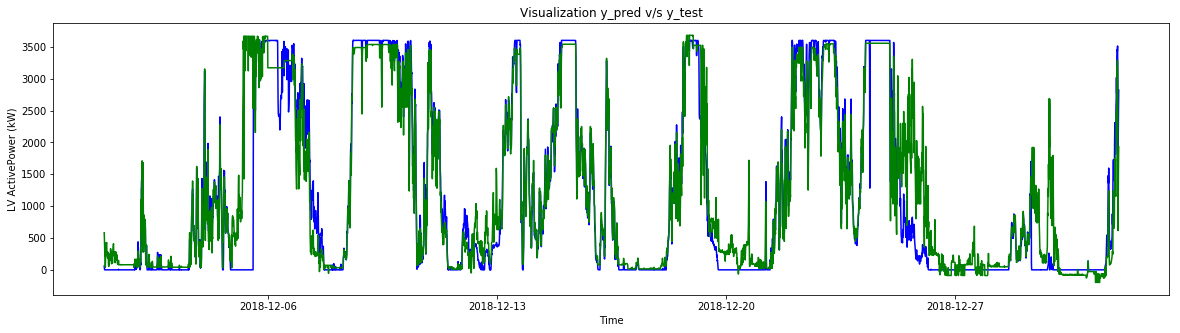

In [41]:
# Plot y_pred v/s y_test)
b = dataset.iloc[46083:50530, 0:1].values
plt.figure(figsize=(20,5))
plt.plot(b, y_test, color='blue', label='Actual Value') 
plt.plot(b, y_pred, color='green', label='Predicted Value')
plt.title('Visualization y_pred v/s y_test')
plt.xlabel('Time')
plt.ylabel('LV ActivePower (kW)')
plt.show()

## One-week measurements in ten-minute intervals

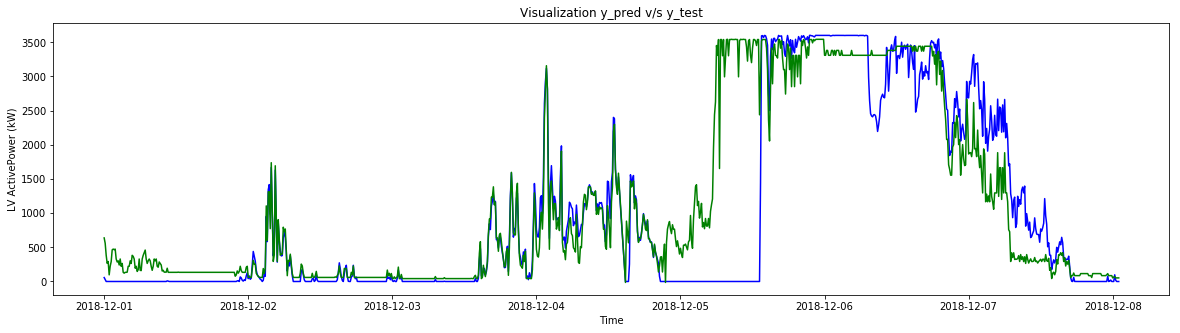

In [21]:
# Plot y_pred v/s y_test)
b = dataset.iloc[46083:47091, 0:1].values
plt.figure(figsize=(20,5))
plt.plot(b, y_test[0:1008], color='blue', label='Actual Value') 
plt.plot(b, y_pred[0:1008], color='green', label='Predicted Value')
plt.title('Visualization y_pred v/s y_test')
plt.xlabel('Time')
plt.ylabel('LV ActivePower (kW)')
plt.show()

## One-day measurements in ten-minute intervals

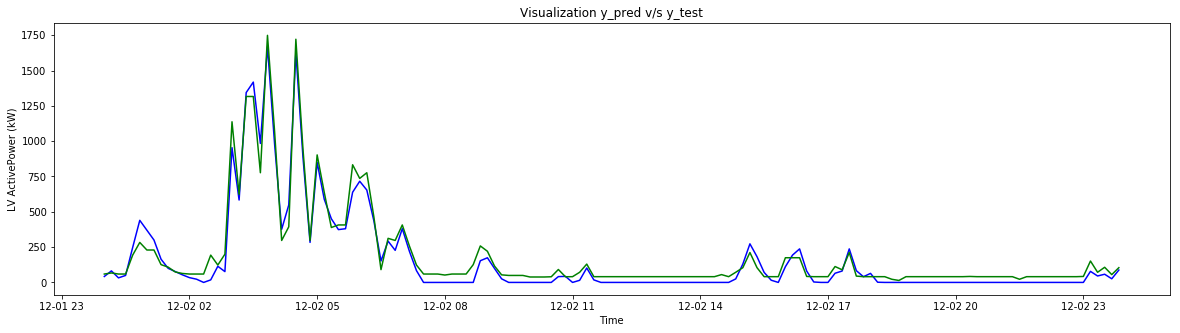

In [41]:
# Plot y_pred v/s y_test)
b = dataset.iloc[46227:46371, 0:1].values
plt.figure(figsize=(20,5))
plt.plot(b, y_test[144:288], color='blue', label='Actual Value') 
plt.plot(b, y_pred[144:288], color='green', label='Predicted Value')
plt.title('Visualization y_pred v/s y_test')
plt.xlabel('Time')
plt.ylabel('LV ActivePower (kW)')
plt.show()

# Suggest the best time to utilize the energy

## Over a Month

### Besrt Hour

In [17]:
# Hour
sum = [0]*24
sum = np.array(sum)
sum = sum.astype('float64')
k =[]
k = np.array(k)
d = -1
for i in range(30):
    for i in range(24):
        c = []
        c = np.array(c)
        temp = 0
        for i in range(6):
            d+=1
            temp+=y_test[d]
        c = np.append(c,values = temp)
    sum+=c

Best Hour to utilize the energy 0
The average production of Energy =  7344.3817145665425


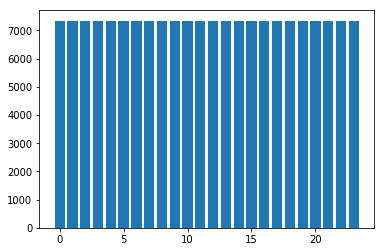

In [18]:
print('Best Hour to utilize the energy', sum.argmax())
print('The average production of Energy = ', max(sum)/30)
plt.bar(range(24), sum/30)
plt.show()

## Over a Year

### Day

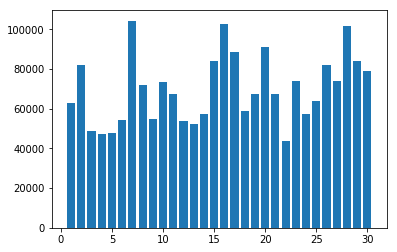

In [19]:
# Day
sum = [0]*30
sum = np.array(sum)
sum = sum.astype('float64')
k =[]
k = np.array(k)
d = -1

for i in range(11):
    c = []
    c = np.array(c)
    for i in range(30):
        temp = 0
        for i in range(144):
            d+=1
            temp+=y[d]
        c = np.append(c,values = temp)
    sum+=c
    
plt.bar(range(1, 31), sum/30)
plt.show()

### Month

In [20]:
# Month
sum = []
sum = np.array(sum)
sum = sum.astype('float64')
k =[]
k = np.array(k)
d = -1
for i in range(12):
    temp = 0
    for i in range(4210):
        d+=1
        temp+=y[d]
    sum = np.append(sum, values = temp)

Best Month to utilize the energy 8
The average production of Energy =  1904.049918401606 each Minute


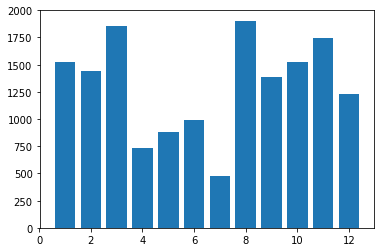

In [21]:
print('Best Month to utilize the energy', sum.argmax()+1)
print('The average production of Energy = ', max(sum)/4210,'each Minute')
plt.bar(range(1, 13), sum/4210)
plt.show()